In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
from transformers import AutoTokenizer
from common import (
    FRED_T5_MODEL_NAME,
    INPUT_TOKEN_LIMIT_FRED_T5,
    TASK_PROMPT,
    MIN_TEXT_TOKENS_FOR_SUMMARIZATION,
    GEMINI_API_KEY,
    GEMINI_MODEL_NAME_PRIMARY
)
import common
from datasets import load_from_disk
import google.generativeai as genai
import os

DATASET_NAME = 'filtered_fontanka'
OUTPUT_JSONL_FILE = "fontanka_generated_summaries.jsonl"
PROCESSED_INDICES_FILE = "fontanka_processed_indices.txt"
FINAL_HF_DATASET_PATH = "fontanka_gemini"
tokenizer = AutoTokenizer.from_pretrained(FRED_T5_MODEL_NAME)

In [2]:
tokens_in_task_prompt_fred_t5 = len(tokenizer(TASK_PROMPT, add_special_tokens=False)['input_ids'])
NUM_SPECIAL_TOKENS_FOR_FRED_T5_INPUT = 1
MAX_TEXT_TOKENS_FOR_FRED_T5_COMPATIBLE_INPUT = INPUT_TOKEN_LIMIT_FRED_T5 - \
                                               tokens_in_task_prompt_fred_t5 - \
                                               NUM_SPECIAL_TOKENS_FOR_FRED_T5_INPUT

In [5]:
raw_dataset = load_from_disk(DATASET_NAME)
print(f"Loaded '{DATASET_NAME}' split with {len(raw_dataset)} examples.")

Loaded 'filtered_fontanka' split with 17377 examples.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [6]:
prepared_dataset_for_gemini = common.preprocess_and_filter_dataset_with_exact_deduplication(
    raw_dataset,
    tokenizer,
    MAX_TEXT_TOKENS_FOR_FRED_T5_COMPATIBLE_INPUT,
    MIN_TEXT_TOKENS_FOR_SUMMARIZATION
)

Starting preprocessing. Initial size: 17377
Targeting max text tokens for processing: 1017


Cleaning, Truncating, and Exact Deduplicating:   0%|          | 0/17377 [00:00<?, ?it/s]

Finished preprocessing. Exact duplicates found and skipped: 37
Filtered dataset size after exact deduplication: 17340


In [7]:
prepared_dataset_for_gemini

Dataset({
    features: ['file', 'processed_text', 'processed_text_tokens'],
    num_rows: 17340
})

<Axes: >

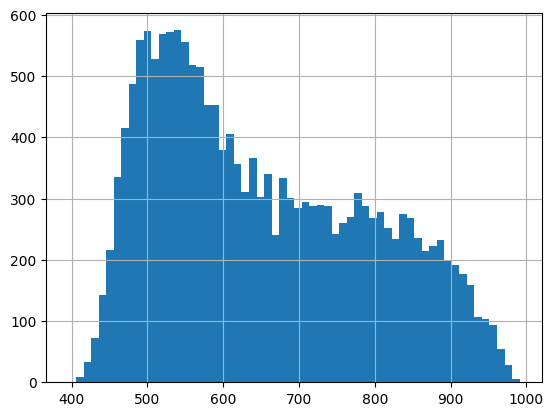

In [8]:
prepared_dataset_for_gemini.to_pandas()['processed_text_tokens'].hist(bins=60)

In [5]:
genai.configure(api_key=GEMINI_API_KEY)
model_gemini = genai.GenerativeModel(GEMINI_MODEL_NAME_PRIMARY)

In [15]:
common.generate_summaries_resumable_full_stats(prepared_dataset_for_gemini, model_gemini, tokenizer, PROCESSED_INDICES_FILE, OUTPUT_JSONL_FILE)

Loaded 17162 already processed indices.
Attempting to process 178 items in this run.


Generating Summaries & Full Stats:   0%|          | 0/178 [00:00<?, ?it/s]


--- Generation Finished for this Run ---
Processed: 178, Total Time: 687.30s, Avg/Item: 3.86s

Source Stats:
  Chars: Avg=2880.73, Min=2160, Max=4557
  Words: Avg=481.01, Min=365, Max=769
  Tokens: Avg=607.98, Min=429, Max=936

All Summary Candidates (534 non-empty):
  Chars:
    Avg=892.52, Min=558, Max=1362
    Comp.: Avg=0.317, Min=0.144, Max=0.515
    25% Quantile: Abs=797.25, Comp.=0.275
    50% Quantile: Abs=891.00, Comp.=0.313
    75% Quantile: Abs=980.00, Comp.=0.356
  Words:
    Avg=138.40, Min=87, Max=194
    Comp.: Avg=0.295, Min=0.139, Max=0.463
    25% Quantile: Abs=125.00, Comp.=0.255
    50% Quantile: Abs=137.00, Comp.=0.294
    75% Quantile: Abs=153.75, Comp.=0.332
  Tokens:
    Avg=183.60, Min=113, Max=258
    Comp.: Avg=0.310, Min=0.157, Max=0.499
    25% Quantile: Abs=164.25, Comp.=0.263
    50% Quantile: Abs=182.00, Comp.=0.309
    75% Quantile: Abs=205.00, Comp.=0.354

Items with no summaries: []
Success distribution:
  3 summaries: 178 items


In [16]:
processed_indices = []
if os.path.exists(PROCESSED_INDICES_FILE): 
    with open(PROCESSED_INDICES_FILE) as f:
        processed_indices = [int(line.strip()) for line in f if line.strip()]
len(processed_indices) == len(set(processed_indices)), len(processed_indices)

(True, 17338)

In [17]:
final_dataset = common.create_final_huggingface_dataset_from_jsonl(OUTPUT_JSONL_FILE, FINAL_HF_DATASET_PATH)
final_dataset

Created Hugging Face dataset with 17338 examples from JSONL.
Saving Hugging Face dataset to fonatka_gemini...


Saving the dataset (0/1 shards):   0%|          | 0/17338 [00:00<?, ? examples/s]

Hugging Face dataset saved.


Dataset({
    features: ['file', 'text', 'summaries'],
    num_rows: 17338
})